# Linear and logistic regression modeling

This notebook introduces two statistical modeling techniques: linear
regression and logistic regression.  The focus here will be on fitting
these two types of models using the Python language, together with its statistical
modeling libraries.  As with several previous case studies in this
course, here we will be analyzing the
[NHANES](https://www.cdc.gov/nchs/nhanes/index.htm)
data, allowing us to
illustrate use of these two regression methods to address meaningful
questions with actual data.

Note that the NHANES data is collected as a designed survey, and in
general should be analyzed as such.  This means that survey design
information such as weights, strata, and clusters should be accounted
for in any analysis using NHANES.  But to introduce how linear and
logistic regression
are used with independent data or with convenience samples, we will not
incorporate the survey structure of the sample into the analyses
conducted here.

As with our previous work, we will be using the
[http://pydata/.org/pandas](Pandas) library for data management, the
[http://numpy.org](Numpy) library for numerical calculations, and the
[http://statsmodels.org](Statsmodels) library for statistical
modeling.

We begin by importing the libraries that we will be using.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

Next we will load the data.  The NHANES study encompasses multiple
waves of data collection.  For illustration, here we will use the
2015-2016 data.

In [2]:
url = "https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv"
da = pd.read_csv(url)

## Linear regression

We will focus initially on regression models in which systolic blood
pressure (SBP) is the outcome (dependent) variable.  That is, we will
predict SBP from other variables.  SBP is an important indicator of
cardiovascular health.  It tends to increase with age, is greater for
overweight people (i.e. people with greater body mass index or BMI),
and also differs among demographic groups, for example among gender
and ethnic groups.

Since SBP is a quantitative variable, we will model it using linear regression.
Linear regression is the most widely-utilized form of statistical
regression.  It is commonly used with quantitative outcome variables.
Linear regression is not the only type of regression model that can be
used with quantitative outcomes, nor is it the case that linear
regression can only be used with quantitative outcomes.  However,
linear regression is a good default starting point for any regression
analysis using a quantitative outcome variable.

We start with a simple linear regression model with only one
covariate, age, predicting SBP.  In the NHANES data, the variable
[BPXSY1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_G.htm#BPXSY1)
contains the first recorded measurement of SBP for a
subject, and [RIDAGEYR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_G.htm#RIDAGEYR)
is the subject's age in years.  The model that
is fit in the next cell expresses the expected SBP as a linear
function of age.

In [3]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     1524.
Date:                Sat, 24 Nov 2018   Prob (F-statistic):          6.35e-294
Time:                        18:26:56   Log-Likelihood:                -22745.
No. Observations:                5401   AIC:                         4.549e+04
Df Residuals:                    5399   BIC:                         4.551e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.5144      0.619    165.540      0.000     101.300     103.728
RIDAGEYR       0.4692      0.012     39.043      0.000       0.446       0.493
==============================================================================
Omnibus:                      784.418   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1825.182
Skew:                           0.840   Prob(JB):                         0.00
Kurtosis:                       5.299   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Much of the results output above is not relevant for us, so focus
on the center section of the output.  This section
contains the estimated values of the parameters of the regression
model, their standard errors, and other quantities.  This fitted model
implies that when comparing two people whose ages differ by one year,
the older person will on average have 0.47 units higher SBP than the
younger person.  This difference is statistically significant, based
on the p-value shown under the column labeled `P>|t|` above.  This
means that there is strong evidence that the association between
between systolic blood pressure and age in this population is not
zero.

SBP is measured in units of 'millimeters of mercury', expressed
'mm/Hg'.  In order to better understand the magnitude of the estimated
parameter 0.47, we can look at the standard deviation of SBP:

In [4]:
da.BPXSY1.std()

18.480872651654913

The standard deviation of around 18.5 is large compared to the
regression slope of 0.47.  However the regression slope corresponds to
the average change in SBP for a single year of age, and this effect
accumulates with age.  Comparing a 40 year-old person to a 60 year-old
person, there is a 20 year difference in age, which translates into a
`20 * 0.47 = 9.4` unit difference in average SBP between these two
people.  This difference is around half of one standard deviation, and
would generally be considered to be an important and meaningful shift.

We will also point out here that in the case of regression with a
single independent variable, as we have here, there is a very close
correspondence between the regression analysis and a Pearson
correlation analysis, which we have discussed earlier in course 2.

The primary summary statistic for assessing the strength of a
predictive relationship in a regression model is the `R^2`, which is
shown to be 0.22 in the regression output above.  This means that 22%
of the variation in SBP is explained by age.  Note that this value is
exactly the same as the squared Pearson correlation coefficient
between SBP and age, as shown below.

In [5]:
cc = da[["BPXSY1", "RIDAGEYR"]].corr()
print(cc.BPXSY1.RIDAGEYR**2)

0.22018005703294224


Above we considered a simple linear regression analysis with only one
covariate (age) predicting systolic blood pressure (SBP).  The real
power of regression analysis arises when we have more than one
covariate predicting an outcome.  As noted above, SBP is expected to
be related to gender as well as to age, so we next add gender to the
model.  The NHANES variable for gender is named [RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/DEMO_G.htm#RIAGENDR]).
We create a relabeled version of this variable below.

In [6]:
# Create a labeled version of the gender variable
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     801.0
Date:                Sat, 24 Nov 2018   Prob (F-statistic):          2.41e-305
Time:                        18:26:56   Log-Likelihood:                -22715.
No. Observations:                5401   AIC:                         4.544e+04
Df Residuals:                    5398   BIC:                         4.546e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           100.9144      0.649    155.443      0.000      99.642     102.187
RIAGENDRx[T.Male]     3.4440      0.442      7.792      0.000       2.578       4.310
RIDAGEYR              0.4677      0.012     39.130      0.000       0.444       0.491
==============================================================================
Omnibus:                      802.560   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1921.111
Skew:                           0.848   Prob(JB):                         0.00
Kurtosis:                       5.379   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model that was fit above uses both age and gender to explain the
variation in SBP.  It finds that two people with the same gender whose
ages differ by one year tend to have blood pressure values differing
by 0.47 units, which is essentially the same as what we found above in
the model based on age alone.  This model also shows us that comparing
a man and a woman of the same age, the man will have 3.44 units
greater SBP.

It is very important to emphasize that the age coefficient of 0.47 is
only meaningful when comparing two people of the same gender, and the
gender coefficient of 3.44 is only meaningful when comparing two
people of the same age.

These effects are additive, meaning that if we compare, say, a 50 year
old man to a 40 year old woman, the man's blood pressure will on
average be around 3.44 + 10*0.47 = 8.14 units higher, with the first
term in this sum being attributable to gender, and the second term
being attributable to age.

Note also that gender is a categorical variable, and only a
coefficient for males is included in the regression output (i.e. there
is no coefficient for females).  Whenever a categorical variable is
used as a covariate in a regression model, one level of the variable
is omitted and is automatically given a coefficient of zero.  This
level is called the *reference level* of the covariate.  Here, the
female level of the gender variable is the reference level.  This does
not mean that being a woman has no impact on blood pressure.  It
simply means that we have written the model so that female blood
pressure is the default, and the coefficient for males (3.44) shifts
the blood pressure by that amount for males only.

We could alternatively have set 'male' to be the reference level, in
which case males would be the default, and the female coefficient
would have been around -3.44 (meaning that female blood pressure is
3.44 units lower than the male blood pressure).

We noted above that the regression coefficient for age did not change
by much when we added gender to the model.  It is important to note
however that in general, the estimated coefficient of a variable in a
regression model will change when other variables are added or
removed.  We see here that a coefficient is nearly unchanged if any
variables that are added to or removed from the model are
approximately uncorrelated with the other covariates that are already
in the model.

Below we confirm that gender and age are nearly uncorrelated in this
data set (the correlation of around -0.01 is negligible):

In [7]:
# We need to use the original, numerical version of the gender
# variable to calculate the correlation coefficient.
da[["RIDAGEYR", "RIAGENDR"]].corr()

,RIDAGEYR,RIAGENDR
RIDAGEYR,1.000000,-0.014613
RIAGENDR,-0.014613,1.000000


Next we add body mass index (BMI) to the model predicting SBP.
[BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_G.htm#BMXBMI)
is the NHANES variable containing the BMI value for each subject.

In [8]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR + BMXBMI + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     574.7
Date:                Sat, 24 Nov 2018   Prob (F-statistic):          9.88e-324
Time:                        18:26:56   Log-Likelihood:                -22409.
No. Observations:                5347   AIC:                         4.483e+04
Df Residuals:                    5343   BIC:                         4.485e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            91.9966      1.111     82.800      0.000      89.818      94.175
RIAGENDRx[T.Male]     3.7808      0.439      8.607      0.000       2.920       4.642
RIDAGEYR              0.4614      0.012     38.832      0.000       0.438       0.485
BMXBMI                0.3078      0.031      9.802      0.000       0.246       0.369
==============================================================================
Omnibus:                      806.802   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1980.135
Skew:                           0.852   Prob(JB):                         0.00
Kurtosis:                       5.447   Cond. No.                         300.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not surprisingly, BMI is positively associated with SBP.  Given two
subjects with the same gender and age, and whose BMI differs by 1
unit, the person with greater BMI will have, on average, 0.31 units
greater systolic blood pressure (SBP).  Also note that after adding
BMI to the model, the coefficient for gender became somewhat greater.
This is due to the fact that the three covariates in the model, age,
gender, and BMI, are mutually correlated, as shown next:

In [9]:
da[["RIDAGEYR", "RIAGENDR", "BMXBMI"]].corr()

,RIDAGEYR,RIAGENDR,BMXBMI
RIDAGEYR,1.000000,-0.014613,0.059597
RIAGENDR,-0.014613,1.000000,0.081811
BMXBMI,0.059597,0.081811,1.000000


Although the correlations among these three variables are not strong,
they are sufficient to induce fairly substantial differences in the
regression coefficients (e.g. the gender coefficient changes from 3.44
to 3.78).  In this example, the gender effect becomes larger after we
control for BMI - we can take this to mean that BMI was masking part
of the association with gender.  In other settings, including
additional covariates can reduce the association between a covariate
and an outcome.

### Variance analysis

The discussion so far has primarily focused on the mean structure
of the regression model, that is, the model for the average
SBP of a person with a given age, gender, and BMI.  A regression
model can also be used to assess the *variance structure* of the
population, that is, how much and in what manner do the observations
deviate from this mean.  We will focus on informal, graphical
methods for assessing this.

To begin with, we plot the residuals against the fitted values.  Recall
that the fitted values are the estimated mean for each observation,
and the residuals are the difference between an observation and this
fitted mean.  The simplest variance pattern that we can see in a
linear regression occurs when the points are scattered around the mean,
with the same degree of scatter throughout the range of covariates.
When there are multiple covariates, it is hard to assess whether
the variance is uniform throughout this range, but we can easily check
for a "mean/variance relationship", in which the variance either increases
or decreases with the mean.  The plot of residuals on fitted values
is used to assess whether a mean/variance relationship is present.

In [10]:
#pp = sns.pointplot(result.fittedvalues, result.resid)
#pp.set_xlabel("Fitted values")
#pp.set_ylabel("Residuals")

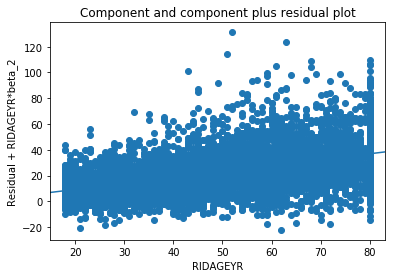

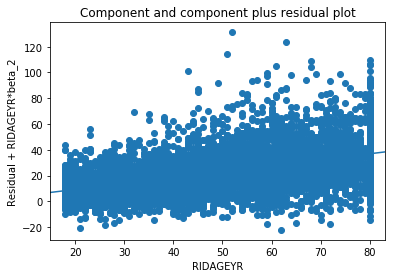

In [11]:
from statsmodels.graphics.regressionplots import plot_ccpr

plot_ccpr(result, "RIDAGEYR")

## Logistic regression

We now turn to regression models for *binary* outcome variables,
meaning an outcome that can take on only two distinct values.
For illustration, we will work with the NHANES variable
[SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020),
which asks whether a person has smoked at least 100 cigarettes in
their lifetime (if this is the case, we say that the person has a
"smoking history").  Below we create a version of this variable in
which smoking and non-smoking are coded as 1 and 0, respectively, and
rare responses like *don't know* and *refused to answer* are coded as
missing values.

In [12]:
da["smq"] = da.SMQ020.replace({2: 0, 7: np.nan, 9: np.nan})

Logistic regression provides a model for the *odds* of an event
happening.  Recall that if an event has probability `p`, then the odds
for this event is `p/(1-p)`.  The odds is a mathematical
transformation of the probability onto a different scale.  For
example, if the probability is 1/2, then the odds is 1.

To begin, we look at the odds of alcohol use for women and men separately.

In [13]:
c = pd.crosstab(da.RIAGENDRx, da.smq).apply(lambda x: x/x.sum(), axis=1)
c["odds"] = c.loc[:, 1] / c.loc[:, 0]
c

smq,0.0,1.0,odds
RIAGENDRx,,,
Female,0.695155,0.304845,0.438529
Male,0.486742,0.513258,1.054478


We see that the probability that a woman has ever smoked is
substantially lower than the probability that a man has ever smoked
(30% versus 51%).  This is reflected in the odds for a woman smoking
being much less than 1 (around 0.44), while the odds for a man smoking
is around 1.05.

It is common to work with *odds ratios* when comparing two groups.
This is simply the odds for one group divided by the odds for the other
group.  The odds ratio for smoking, comparing males to females, is
around 2.4.  In other words, a man has around 2.4 times greater odds of
smoking than a woman (in the population represented by these data).

In [14]:
c.odds.Male / c.odds.Female

2.404581397647524

It is conventional to work with odds on the logarithmic scale.  To understand
the motivation for doing this, first note that the neutral point for a
probability is 0.5, which is equivalent to an odds of 1 and a log odds
of 0.  Populations where men smoke more than women will have odds
between 1 and infinity, with the exact value depending on the
magnitude of the relationship between the male and female smoking
rates.  Populations where women smoke more than men would have odds
falling between 0 and 1.

We see that the scale of the odds statistic is asymmetric.  It is
usually arbitrary in which order we compare two groups -- we could
compare men to women, or compare women to men.  An odds of 2 (men have
twice the odds of smoking as women) is equivalent in strength to an
odds of 1/2 (women have twice the odds of smoking as men).  Taking the
log of the odds centers the scale at zero, and symmetrizes the
interpretation of the scale.

To interpret the log odds when comparing the odds for two groups,
first recall that a probability of 1/2, an odds of 1, and a log odds
of 0 are all equivalent.  A positive log odds indicates that the first
group being compared has greater odds (and greater probability) than
the second group, and a negative log odds indicates that the second
group being compared has greater odds (and greater probability) than
the first group.  The scale of the log odds statistic is symmetric in
the sense that a log odds of, say, 2, is equivalent in strength to a
log odds of -2 (but with the groups swapped in terms of which has the
greater probability).

If you know that the log odds when comparing two groups is a given
value, say 2, and you want to report the odds, you simply exponentiate
the log odds to get the odds, e.g. `exp(2)` is around 7.4. Note
however that you cannot recover the individual probabilities (or their
ratio) from an odds ratio.`

Below we show the log odds for smoking history status of females and
males in the NHANES data.  The fact that the log odds for females is
negative reflects that fact that substantially less than 50% of
females have a history of smoking.  The log odds for males is around
0, consistent with around half of males having a history of smoking.

In [15]:
c["logodds"] = np.log(c.odds)
c

smq,0.0,1.0,odds,logodds
RIAGENDRx,,,,
Female,0.695155,0.304845,0.438529,-0.824330
Male,0.486742,0.513258,1.054478,0.053045


Now that we have a clear understanding of log odds statistics, we wil fit
a logistic regression.  The dependent variable (outcome) of this
initial model is smoking status, and the only covariate is gender.
Thus, we are looking at gender as a predictor of smoking status.  We
fit the model using the `GLM` function, where `GLM` stands for
"Generalized Linear Model".  Logistic regression is one type of GLM,
which also includes many other regression methods such as Poisson
regression that we do not discuss further here.  As with linear
regression, logistic models also include an intercept parameter, but
we are not focusing on that parameter now.

In [16]:
model = sm.GLM.from_formula("smq ~ RIAGENDRx", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5725
Model:                            GLM   Df Residuals:                     5723
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3734.8
Date:                Sat, 24 Nov 2018   Deviance:                       7469.6
Time:                        18:26:57   Pearson chi2:                 5.72e+03
No. Iterations:                     4   Covariance Type:             nonrobust
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8243      0.040    -20.687      0.000      -0.902      -0.746
RIAGENDRx[T.Male]     0.8774      0.055     15.908      0.000       0.769       0.985
=====================================================================================
"""

To see the connection between logistic regression and the log odds
statistic, note that the difference between the log odds statistics
for males and females is exactly equal to the logistic regression
coefficient for male gender:

In [17]:
c.logodds.Male - c.logodds.Female

0.877375833376175

This relationship will always hold when
conducting a logistic regression with a single binary covariate.

In general, a logistic regression model will have multiple covariates
that may not be binary, but there is still an important connection
between logistic regression and odds ratios.  In this more general setting, we will
use a more general type of odds ratio, which we will explore further
next.

As with linear regression, we can include multiple covariates in a logistic
regression.  Below we fit a logistic regression for smoking status
using age (RIDAGEYR) and gender as covariates.

In [18]:
model = sm.GLM.from_formula("smq ~ RIDAGEYR + RIAGENDRx", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5725
Model:                            GLM   Df Residuals:                     5722
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3637.6
Date:                Sat, 24 Nov 2018   Deviance:                       7275.2
Time:                        18:26:57   Pearson chi2:                 5.73e+03
No. Iterations:                     4   Covariance Type:             nonrobust
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.8635      0.088    -21.259      0.000      -2.035      -1.692
RIAGENDRx[T.Male]     0.8978      0.056     15.967      0.000       0.788       1.008
RIDAGEYR              0.0211      0.002     13.720      0.000       0.018       0.024
=====================================================================================
"""

Adding age to the model leads to a very small shift in the gender
parameter (it changed from 0.88 to 0.90).
In general, regression coefficients can change a lot when adding or
removing other variables from a model.  But in this case the change is
quite minimal.  This fitted model suggests that older people are more
likely to have a history of smoking than younger people.  The log odds
for smoking increases by 0.02 for each year of age.  This effect is
additive, so that comparing two people whose ages differ by 20 years,
the log odds of the older person smoking will be around 0.4 units
greater than the log odds for the younger person smoking.

Similarly, the roles of age and gender in the model are additive.  If
we compare a 30 year old female to a 50 year old male, the log odds
for the male being a smoker are `0.9 + 0.4 = 1.3` units greater than
the log odds for the female being a smoker.  The value of 0.9 in this
expression is the change attributable to gender, and the value of 0.4 is
the change attributable to age.

In this logistic regression model with two covariates, the
coefficients for age and gender both have interpretations in terms of
*conditional log odds*.  This generalizes the interpretation of a
logistic regressioncoefficient in terms of marginal log odds that we discussed above.
When there are two or more covariates in a logistic regression model,
we always need to think in terms of conditional, not marginal log odds.

The coefficient of around 0.9 for male gender impacts the conditional
log odds in the sense that when comparing a male to a female at a
fixed age, the male will have 0.9 units greater odds for smoking than
the female.  This relationship holds within any age (i.e. it holds
among all people of age 30, and among all people of age 70).  In this
sense, it is a *conditional* coefficient because it is only
interpretable when holding the other variables in the model fixed.

Similarly, the coefficient of around 0.02 for age holds within a
gender.  Comparing two females whose ages differ by one year, the
older female has 0.02 units greater log odds for smoking than the
younger female.  This same contrast holds for males.

Next we fit a logistic regression model, again for smoking, including
educational attainment as a predictor.  The educational attainment in
NHANES is called [DMDEDUC2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_G.htm),
and we will recode it so that the meaning
of the levels becomes more clear.  We will call the recoded variable
`DMDEDUC2x`.

When using a categorical variable as a predictor in a regression
model, it is recoded into "dummy variables" (also known as "indicator
variables").  A dummy variable for a single level, say `a`, of a
variable `x`, is a variable that is equal to `1` when `x=a` and is
equal to `0` when `x` is not equal to `a`.  These dummy variables are
included in the regression model, to represent the variable that they
are derived from.  For technical reasons, one of these variables must
be dropped.  The level that is dropped is called the "reference level"
of the variable.  Most software will automatically recode a
categorical variable into dummy variables, and will select a reference
level.  When interpreting the regression output, the level that is
omitted should be seen as having a coefficient of 0, with a standard
error of 0.

In [19]:
da["DMDEDUC2x"] = da.DMDEDUC2.replace({1: "lt9", 2: "x9_11", 3: "HS", 4: "SomeCollege",
                                       5: "College", 7: np.nan, 9: np.nan})
model = sm.GLM.from_formula("smq ~ RIDAGEYR + RIAGENDRx + DMDEDUC2x", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5463
Model:                            GLM   Df Residuals:                     5456
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3421.3
Date:                Sat, 24 Nov 2018   Deviance:                       6842.6
Time:                        18:26:58   Pearson chi2:                 5.47e+03
No. Iterations:                     4   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.3330      0.111    -21.108      0.000      -2.550      -2.116
RIAGENDRx[T.Male]            0.9313      0.058     15.986      0.000       0.817       1.045
DMDEDUC2x[T.HS]              0.9345      0.087     10.761      0.000       0.764       1.105
DMDEDUC2x[T.SomeCollege]     0.8425      0.082     10.338      0.000       0.683       1.002
DMDEDUC2x[T.lt9]             0.2357      0.106      2.230      0.026       0.029       0.443
DMDEDUC2x[T.x9_11]           1.0745      0.103     10.426      0.000       0.872       1.276
RIDAGEYR                     0.0185      0.002     11.061      0.000       0.015       0.022
============================================================================================
"""

We see that the "Female" level of the gender variable, and the
"College" level of the educational attainment variable are the
reference levels, as they are not shown in the output above.  We have
discussed the gender and age variables above, but the educational
attainment variable is new for us.  All non-refernece coefficients for the
educational attainment are positive, while the `College` coefficient,
as the reference coefficient, is exactly zero.  Thus, we see that people
with a college degree have the lowest rate
of smoking, followed by people with less than 9 years of schooling,
then people with some college, then people with a high school degree
(and no college), and finally (with the greatest rate of smoking),
people with 9-11 years of schooling.  The overall story here is that
smoking rates are much lower for people who graduated from college or
did not start high school, presumably for very different reasons.  On
the other hand, people with some high school, people who completed
high school, and people who began but did not complete college have
much higher rates of smoking.  The odds ratio between the former and
the latter group depends on the specific subgroups being compared, but
can be almost 3 (`exp(1.07)`).

As noted above when we were discussing linear regression, it is
important to remember that a coefficient in a logistic regression are
"conditional" on the other variables being held fixed.  For example,
the log odds ratio of 1.07 between people with 9-11 years of schooling
and people who completed college applies when comparing people with
the same age and gender.